In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

## 1. Data loading and initial exploration

In [179]:
# Data loading
path = r'../data/raw/data_raw.csv'
alzheimer_df = pd.read_csv(path)

In [180]:
# Data dimensions and types 
print("data shape: ", alzheimer_df.shape)
print("data types:\n", alzheimer_df.dtypes)

data shape:  (329637, 14)
data types:
 Año               int64
Semana           object
Pag.              int64
Cuadro           object
No_01           float64
Entidad          object
No_02           float64
Padecimiento     object
Ax_001            int64
Ax_002           object
Ax_003           object
No_03           float64
Valor            object
No_04           float64
dtype: object


In [181]:
# Confirming structure
alzheimer_df.head()

,Año,Semana,Pag.,Cuadro,No_01,Entidad,No_02,Padecimiento,Ax_001,Ax_002,Ax_003,No_03,Valor,No_04
0,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,0,Sem.,NaN,1,NaN
1,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,H,NaN,1,NaN
2,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,M,NaN,-,NaN
3,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson\nCIE-10ª REV.\nG20,2014,0,Sem.,NaN,-,NaN
4,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson\nCIE-10ª REV.\nG20,2014,Acum.,H,NaN,-,NaN


## 2. Preliminary cleaning

In [182]:
#Filtering only the rows about alzheimers disease
alzheimer_df = alzheimer_df[alzheimer_df["Padecimiento"].str.startswith("Enfermedad de Alzheimer", na=False)]

In [183]:
#cleaning innecesary columns
alzheimer_df = alzheimer_df.drop(["Pag.", "Cuadro ", "No_01", "No_02", "No_03", "No_04", "Ax_001", "Ax_002", "Padecimiento"], axis=1)

In [184]:
# replacing "-" by "0"
alzheimer_df["Valor"] = alzheimer_df["Valor"].replace("-", "0")

# converting to numeric data type
alzheimer_df["Valor"] = pd.to_numeric(alzheimer_df["Valor"], errors="coerce")

In [185]:
# Converting "Semana" to a numeric data type
alzheimer_df["Semana"] = alzheimer_df["Semana"].str.replace("sem", "", regex=False).astype(int)

In [186]:
# replacing Entidad name 
alzheimer_df["Entidad"] = alzheimer_df["Entidad"].replace("Distrito Federal", "Ciudad de México")

In [187]:
# Removing redundant data

# Removing rows with "Acum." in "Ax_003" column
alzheimer_df = alzheimer_df[alzheimer_df["Ax_003"] != "Acum."]

# Removing rows with "TOTAL" in "Entidad" column
alzheimer_df = alzheimer_df[alzheimer_df["Entidad"] != "TOTAL"]

In [188]:
# Missing values
nan_counts = alzheimer_df.isna().sum()
columnas_con_nan = nan_counts[nan_counts > 0]
columnas_con_nan_ordenadas = columnas_con_nan.sort_values(ascending=False)
print(columnas_con_nan_ordenadas)

Valor    1
dtype: int64


In [189]:
# Duplicated rows
alzheimer_df.duplicated().sum()

np.int64(0)

In [190]:
suma = alzheimer_df["Valor"].sum()
print(suma)

745043.0


In [191]:
alzheimer_df.head(20)

,Año,Semana,Entidad,Ax_003,Valor
6,2014,2,Aguascalientes,Sem.,0.0
7,2014,2,Aguascalientes,H,0.0
8,2014,2,Aguascalientes,M,0.0
15,2014,2,Baja California,Sem.,0.0
16,2014,2,Baja California,H,0.0
17,2014,2,Baja California,M,0.0
24,2014,2,Baja California Sur,Sem.,0.0
25,2014,2,Baja California Sur,H,0.0
26,2014,2,Baja California Sur,M,0.0
33,2014,2,Campeche,Sem.,0.0


## 3. Useful subset selection

In [192]:
# Pivot Ax_003 to get separate columns for each category
df_pivot = alzheimer_df.pivot_table(
    index=["Año", "Semana", "Entidad"],
    columns="Ax_003",
    values="Valor",
    aggfunc="first"
).reset_index()

df_pivot = df_pivot.rename(columns={
    "Sem.": "Casos_Semanal_Total",
    "H": "Casos_Acum_Hombres",
    "M": "Casos_Acum_Mujeres"
})

df_pivot.columns.name = None

df_subset = df_pivot.drop('Casos_Semanal_Total', axis=1)

df_subset.head()

,Año,Semana,Entidad,Casos_Acum_Hombres,Casos_Acum_Mujeres
0,2014,2,Aguascalientes,0.0,0.0
1,2014,2,Baja California,0.0,0.0
2,2014,2,Baja California Sur,0.0,0.0
3,2014,2,Campeche,0.0,0.0
4,2014,2,Chiapas,0.0,0.0


## 4. Consistency validation

In [193]:
# Sorting values for consistency checks
df_sorted = df_pivot.sort_values(["Entidad", "Año", "Semana"])

# Calculate week-to-week differences
df_sorted["Delta_H"] = df_sorted.groupby(["Entidad"])["Casos_Acum_Hombres"].diff()
df_sorted["Delta_M"] = df_sorted.groupby(["Entidad"])["Casos_Acum_Mujeres"].diff()

# Verify inconsistencies
df_inconsistencies = df_sorted[
    (df_sorted["Delta_H"] < 0) |
    (df_sorted["Delta_M"] < 0) |
    ((df_sorted["Casos_Semanal_Total"] > 0) &
     ((df_sorted["Delta_H"] + df_sorted["Delta_M"]) != df_sorted["Casos_Semanal_Total"]))
]
df_inconsistencies = df_inconsistencies[df_inconsistencies["Semana"] != 2]
print(f"Number of inconsistencies found: {len(df_inconsistencies)}")


Number of inconsistencies found: 547


In [194]:
df_inconsistencias.head()

,Año,Semana,Entidad,Casos_Acum_Hombres,Casos_Acum_Mujeres,Casos_Semanal_Total,Delta_H,Delta_M
3040,2015,44,Aguascalientes,3.0,9.0,0.0,0.0,-1.0
3936,2016,20,Aguascalientes,17.0,18.0,1.0,12.0,9.0
3968,2016,21,Aguascalientes,5.0,9.0,0.0,-12.0,-9.0
4000,2016,22,Aguascalientes,6.0,11.0,2.0,1.0,2.0
4352,2016,33,Aguascalientes,13.0,21.0,1.0,2.0,1.0


## 5. Univariate analysis

### - Distribution of cases per week throughout Mexico

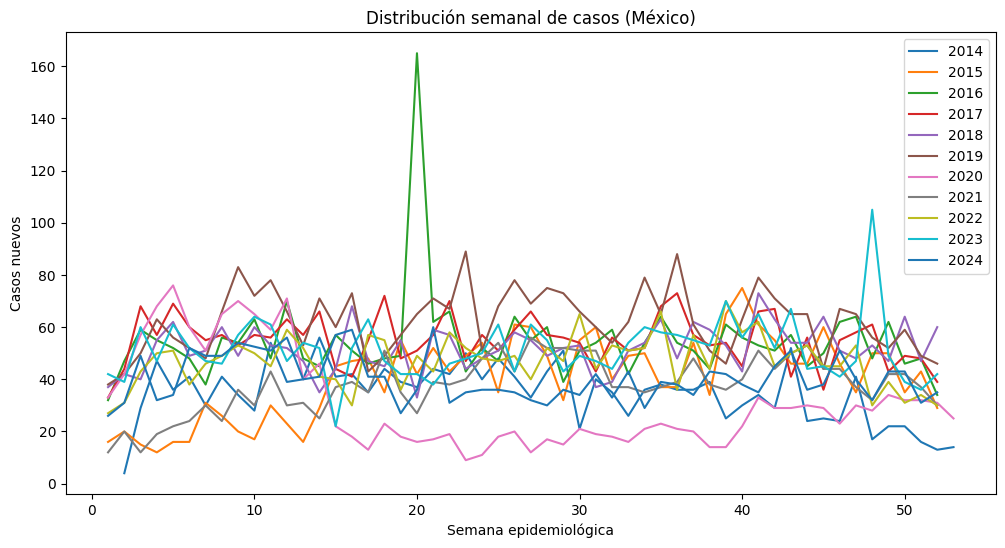

In [195]:
# Agrupar por año y semana, sumando todos los estados
semanal_mexico = df_pivot.groupby(["Año", "Semana"])["Casos_Semanal_Total"].sum().reset_index()

# Graficar todas las curvas, un color por año
plt.figure(figsize=(12,6))
for año, grupo in semanal_mexico.groupby("Año"):
    plt.plot(grupo["Semana"], grupo["Casos_Semanal_Total"], label=str(año))

plt.title("Distribución semanal de casos (México)")
plt.xlabel("Semana epidemiológica")
plt.ylabel("Casos nuevos")
plt.legend()
plt.show()

### - Annual distribution of cases

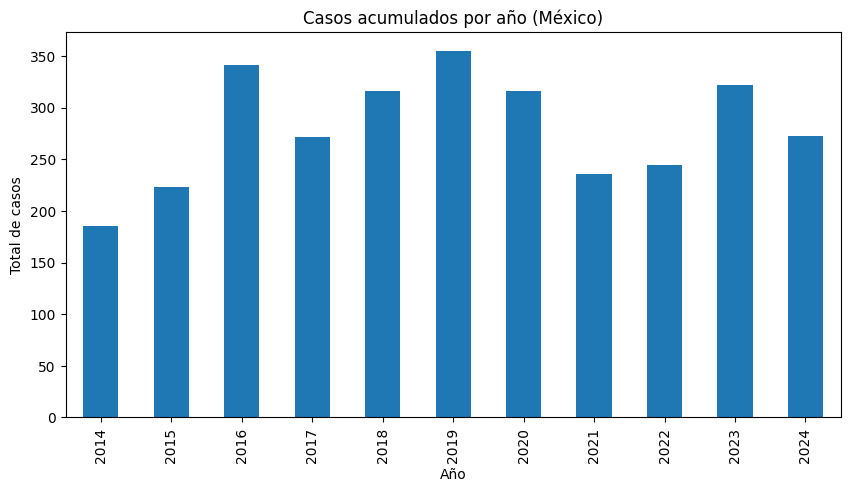

In [196]:
# Tomamos el acumulado final (última semana) de cada año y entidad
anual_mexico = df_subset.groupby(["Año"])[["Casos_Acum_Hombres", "Casos_Acum_Mujeres"]].max().sum(axis=1)

# Gráfico
anual_mexico.plot(kind="bar", figsize=(10,5))
plt.title("Casos acumulados por año (México)")
plt.xlabel("Año")
plt.ylabel("Total de casos")
plt.show()

### - Average and variability by state

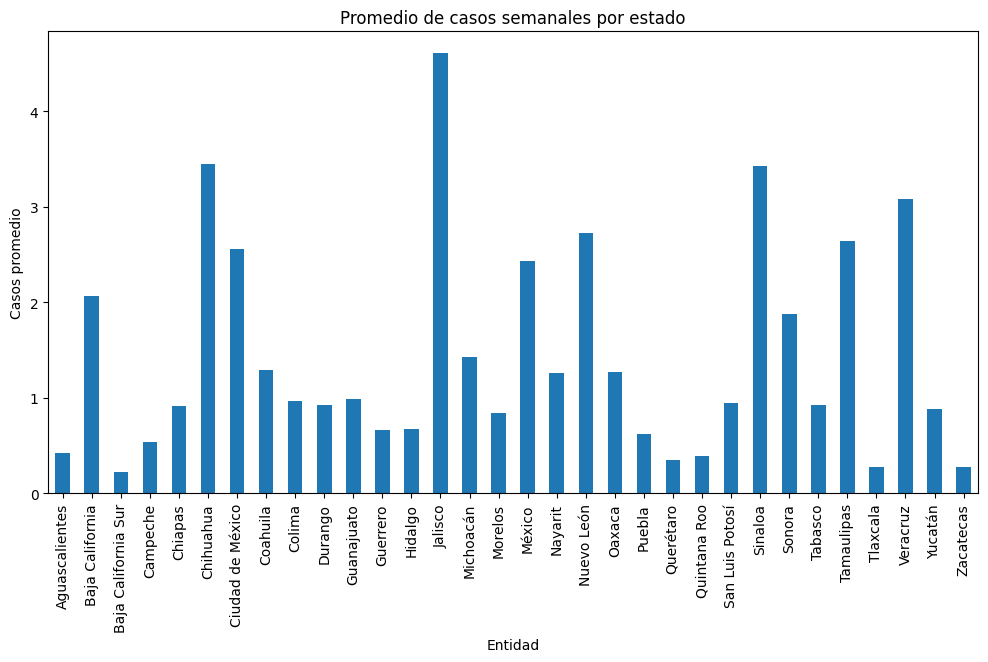

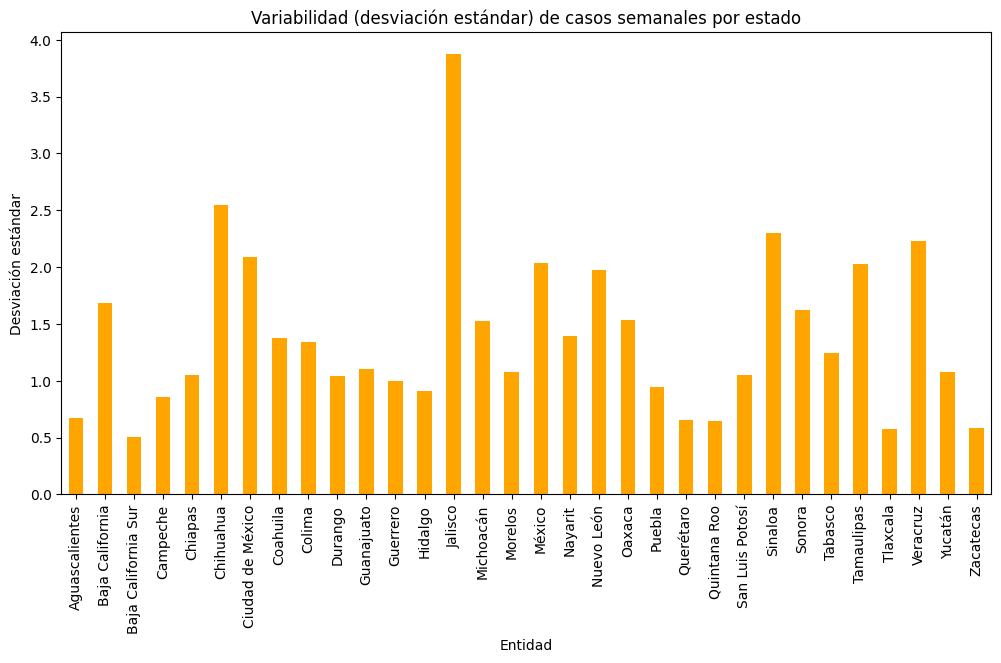

In [197]:
# Promedio y std de casos semanales por estado
estadisticas_estado = df_pivot.groupby("Entidad")["Casos_Semanal_Total"].agg(["mean","std"]).reset_index()

# Promedio
estadisticas_estado.plot(x="Entidad", y="mean", kind="bar", figsize=(12,6), legend=False)
plt.title("Promedio de casos semanales por estado")
plt.ylabel("Casos promedio")
plt.xticks(rotation=90)
plt.show()

# Variabilidad
estadisticas_estado.plot(x="Entidad", y="std", kind="bar", figsize=(12,6), legend=False, color="orange")
plt.title("Variabilidad (desviación estándar) de casos semanales por estado")
plt.ylabel("Desviación estándar")
plt.xticks(rotation=90)
plt.show()

## 6. Bivariate Analysis

### - Men vs Women

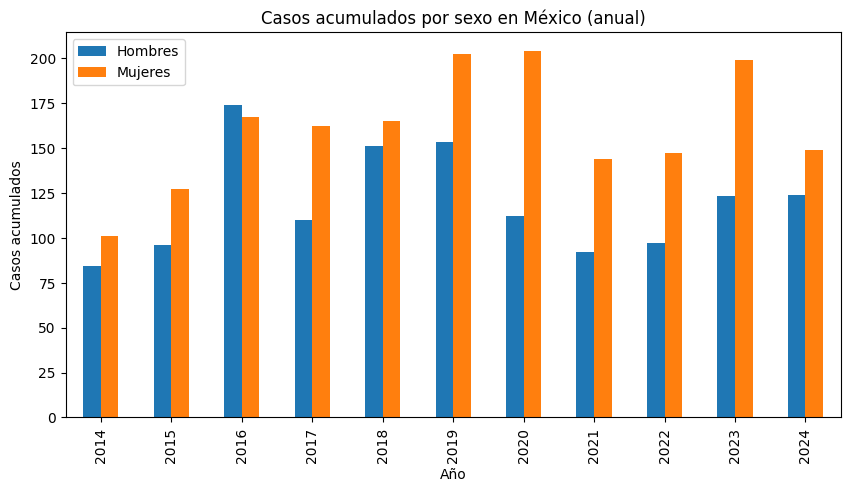

In [198]:
# Total acumulado por año, separados Hombres/Mujeres
anual_sexo = df_subset.groupby("Año")[["Casos_Acum_Hombres", "Casos_Acum_Mujeres"]].max()

# Gráfico comparativo
anual_sexo.plot(kind="bar", figsize=(10,5))
plt.title("Casos acumulados por sexo en México (anual)")
plt.xlabel("Año")
plt.ylabel("Casos acumulados")
plt.legend(["Hombres", "Mujeres"])
plt.show()

### - Time series by entity

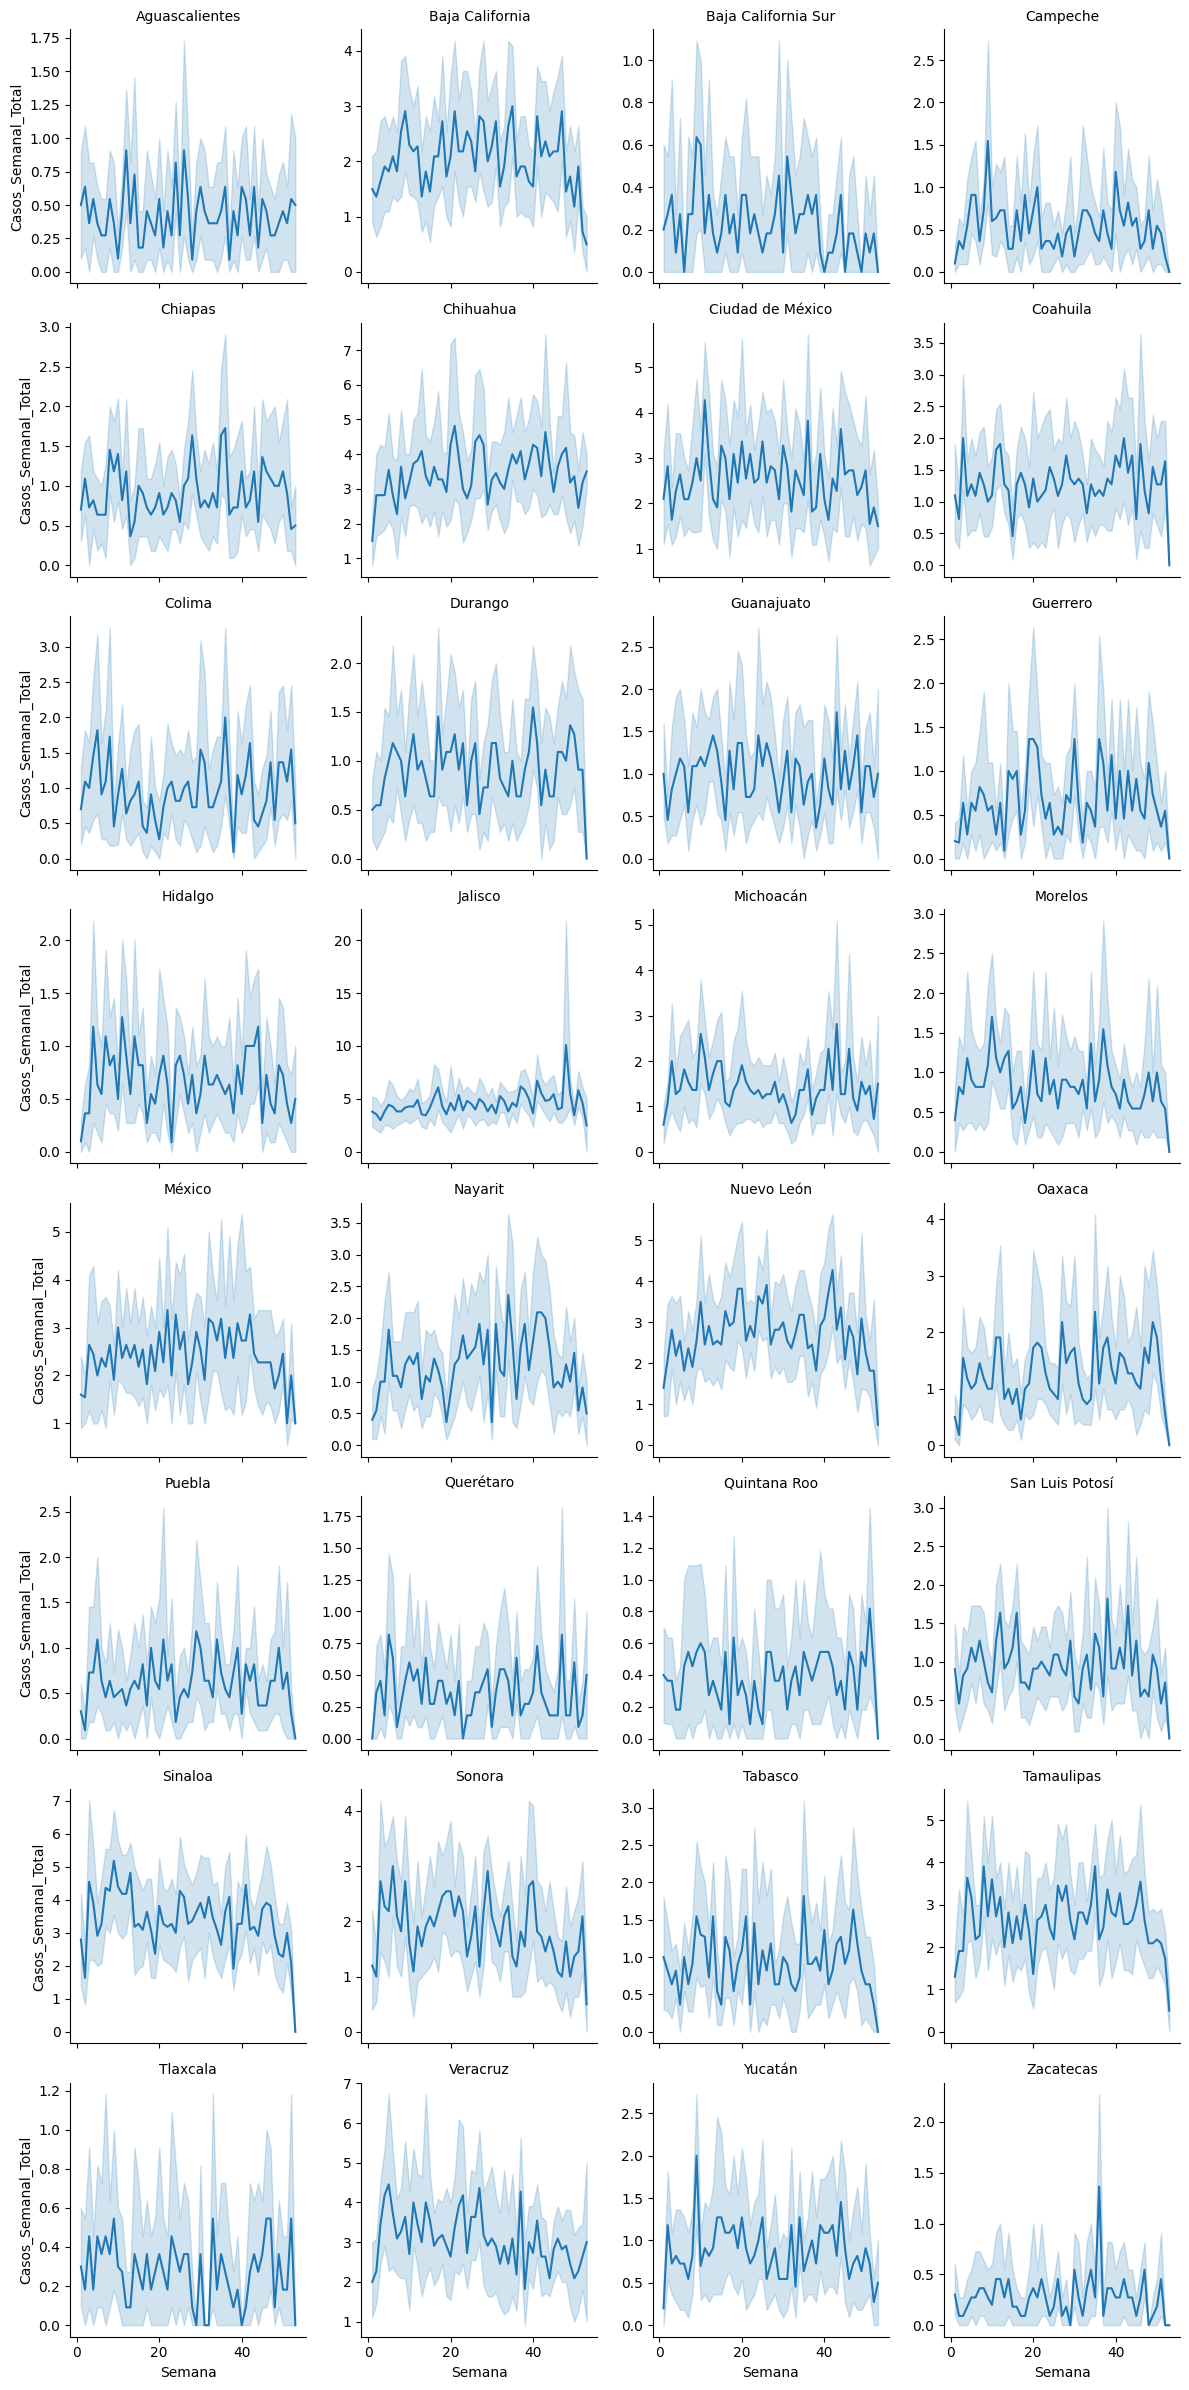

In [199]:
g = sns.FacetGrid(df_pivot, col="Entidad", col_wrap=4, height=3, sharey=False)
g.map_dataframe(sns.lineplot, x="Semana", y="Casos_Semanal_Total")
g.set_titles("{col_name}")
plt.show()

### - Annual and seasonal trends

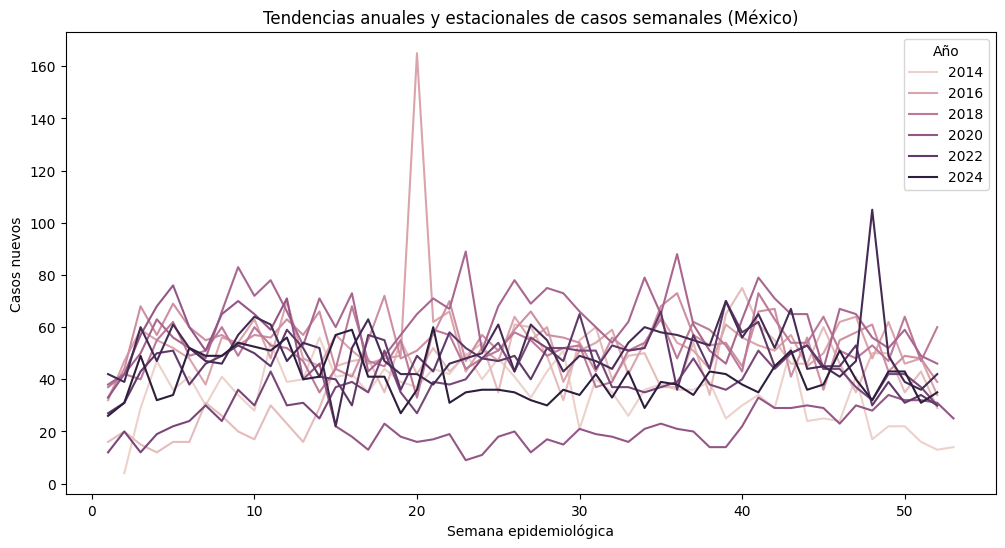

In [200]:
# Promedio de casos semanales por año y semana (todo México)
tendencias = df_pivot.groupby(["Año","Semana"])["Casos_Semanal_Total"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=tendencias, x="Semana", y="Casos_Semanal_Total", hue="Año")
plt.title("Tendencias anuales y estacionales de casos semanales (México)")
plt.xlabel("Semana epidemiológica")
plt.ylabel("Casos nuevos")
plt.show()